# Introduction

Founded in 1988, Wine Enthusiast is an online magazine that provides information on wine trends, ratings and reviews. Their parent company, Wine Enthusiast Companies, is a prominent multichannel marketer of a growing line of wine products in the wholesale, retail and consumer-direct markets. This data set offers opportunities for analysis of the reviews on a good variety of wine from all over the world. 

Our goal is to use machine learning models to predict the country of origin, price or rating of a wine based on its description and other features in the review, as well as gauge the sentiment in these reviews. The results from this endeavour can be used to build a wine recommender through a mobile or web application, providing business value to wine retailers looking to provide meaningful recommendations to their clientele.

# Data Preprocessing & Feature Engineering

In [2]:
# Load all necessary libraries and set matplotlib magic command
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import FreqDist
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### About the Data Set

The data set was obtained from Kaggle and originated from WineEnthusiast. It has a total of 130,000 rows and 13 columns (country, description, designation, points, price, province, region_1, region_2, taster_name, taster_twitter_handle, title, variety, winery).

Additional features such as vintage (year) and description length were also extracted from the data.

In [3]:
# read the wine magazine dataset that we will use for the analysis
wine_df = pd.read_csv("wine/winemag-data-130k-v2.csv", index_col=0)

First, let's the first five rows of the dataset to get an idea of how the data looks like. From the dataset, we can see that it is mostly text-based, with only two columns (points and price) consisting of numerical values. There are also some null values in the dataset that we will have to handle for the analysis.

In [4]:
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Adding the vintage feature

The **vintage** of the wine is often stated in the review title. This might be a useful feature for analysis. Years less than 1945 are excluded  to avoid extracting incorrect data such as estate founded year or estate name, which could also appear in the title.

In [5]:
years = wine_df.title.str.extract('([1-2][0-9]{3})').astype('float64')
years[years < 1945] = None
wine_df = wine_df.assign(vintage = years)

### Handling missing values

We can visualise **missing values** by using a Seaborn heatmap or by isna(). We can deal with missing values in numerical data like price by filling them with mean values or taking the values of the neighbours and predicting the missing values.

In [6]:
wine_df.isna().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
vintage                   4783
dtype: int64

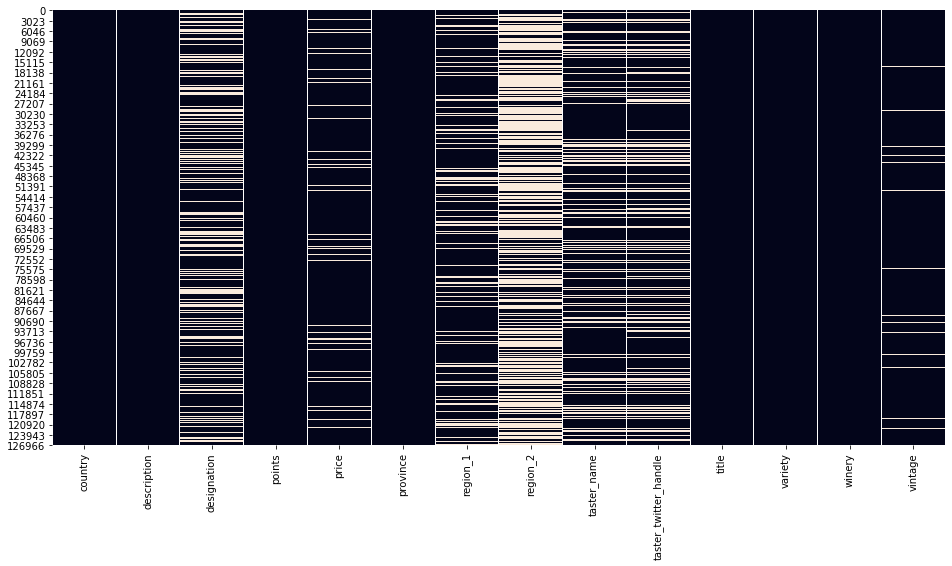

In [7]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(wine_df.isnull(), cbar=False);

There are missing prices for almost 7% of all the entries. We can fill the missing values in price by taking the mean value of all the prices.

In [8]:
wine_df['price'] = wine_df['price'].fillna(wine_df['price'].mean()).round(2)

There are more than more than 9900 **duplicated reviews** (~8%) in the original dataset. We can clean the data by dropping the repeated entries using the drop_duplicates method.

In [9]:
print("Total number of reviews: ", wine_df.shape[0])
print("Number of duplicate reviews (with the same title and description): ", wine_df[wine_df.duplicated(['description','title'])].shape[0])

Total number of reviews:  129971
Number of duplicate reviews (with the same title and description):  9983


In [10]:
#wine_df[wine_df['description'].duplicated(keep = False)].sort_values('description').head() # view duplicate entries
wine_df = wine_df.drop_duplicates('description') # drop duplicate entries

### Considering the description length

As the dataset consists mainly of text elements, we could include additional numerical feature by **considering the length of the description (either number of characters or number of words)** and adding it as a new feature (column) to the dataset. To do the latter, we need to use do some basic preprocessing of the description text through **tokenizing**.

In [11]:
# change all words to lowercase and remove punctuation
wine_df['description']= wine_df['description'].str.lower()
wine_df['description']= wine_df['description'].apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))  
wine_df['description'].head()

0    aromas include tropical fruit  broom  brimston...
1    this is ripe and fruity  a wine that is smooth...
2    tart and snappy  the flavors of lime flesh and...
3    pineapple rind  lemon pith and orange blossom ...
4    much like the regular bottling from       this...
Name: description, dtype: object

In [12]:
ws = WhitespaceTokenizer()
description_words = wine_df['description'].apply(ws.tokenize)
description_words.head()
wine_df['desc_num_words']= [len(tokens) for tokens in description_words]

In [13]:
# count number of characters in each description
wine_df = wine_df.assign(description_length = wine_df['description'].apply(len))

### Transforming points into rating categories

The points start from a score of 80 and goes up to 100. We can further classify it using categories from 'Acceptable' to 'Classic' based on Wine Enthusiast's rating scale:
<img src="wine/critics2.jpg"
     alt="Rating Scale"
     width="700" />

In [14]:
# Transform points to WineMag classification; 
# 98 to 100: Classic  ; 94 to 97: Superb
# 90 to 93: Excellent ; 87 to 89: Very Good
# 83 to 86: Good      ; 80 to 82: Acceptable
wine_df['class'] = pd.cut(wine_df.points, [79, 82, 86, 89, 93, 97, 100], labels=[1,2,3,4,5,6])
wine_df['class_named'] = wine_df['class'].map({1:'Acceptable', 2:'Good', 3:'Very Good', 
                                               4:'Excellent', 5:'Superb', 6:'Classic'}) 

Let's have a quick look at the dataset again before we proceed with exploratory data analysis.

In [15]:
# Some summary statistics after data prep:
print("Number of Reviews: {}, Features: {}".format(wine_df.shape[0],wine_df.shape[1]))
print("Unique Wine Varieties: {}".format((wine_df.variety.nunique())))
print("Unique Wineries: {}".format(wine_df.winery.nunique()))
print("Countries: {}".format(wine_df.country.nunique()))
print("Vintages: {}".format(wine_df.vintage.nunique()))
print("Tasters: {}".format(wine_df.taster_name.nunique()))

Number of Reviews: 119955, Features: 18
Unique Wine Varieties: 707
Unique Wineries: 16755
Countries: 43
Vintages: 53
Tasters: 19


In [16]:
wine_df.sample(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,desc_num_words,description_length,class,class_named
74086,Portugal,this is a beautiful wine rich smooth and bala...,Alqueve de Pinhal da Torre,91,36.0,Tejo,NaN,NaN,Roger Voss,@vossroger,Pinhal da Torre 2009 Alqueve de Pinhal da Torr...,Portuguese Red,Pinhal da Torre,2009.0,35,203,4,Excellent
40855,Spain,pear and melon aromas are mild but clean this...,Vendimia Seleccionada,87,12.0,Northern Spain,Rioja,NaN,Michael Schachner,@wineschach,Bodegas Muriel 2015 Vendimia Seleccionada Viur...,Viura,Bodegas Muriel,2015.0,31,185,3,Very Good
1297,Italy,from what are considered as the highest vineya...,Tradizionale Blanc de Morgex et de La Salle,89,20.0,Northwestern Italy,Valle d'Aosta,NaN,Kerin O’Keefe,@kerinokeefe,Cave du Vin Blanc de Morgex et de la Salle 201...,Prié Blanc,Cave du Vin Blanc de Morgex et de la Salle,2013.0,39,257,3,Very Good


# Exploratory Data Analysis

##  1. Initial Thoughts

In [17]:
wine_df.describe()

,points,price,vintage,desc_num_words,description_length
count,119955.000000,119955.000000,115526.000000,119955.000000,119955.000000
mean,88.442291,35.602323,2010.589244,41.175291,242.815939
std,3.093029,40.608325,3.665845,11.320133,67.146799
min,80.000000,4.000000,1945.000000,3.000000,20.000000
25%,86.000000,18.000000,2009.000000,33.000000,197.000000
50%,88.000000,28.000000,2011.000000,40.000000,237.000000
75%,91.000000,40.000000,2013.000000,48.000000,283.000000
max,100.000000,3300.000000,2017.000000,136.000000,829.000000


Looking at the numerical data, we can **observe a few bits of interesting information**:<br>
- Mean price around 35 dollars. Cheapest wine cost 4 dollars, while the most expensive costs a whopping 3300 dollars.
- Worst wine scores 80 points, while the best tops out at 100. That's because the WineMag only publishes reviews with scores >=80. This is something we need to consider in the subsequent analysis.
- Most recent wines reviewed are the 2017 vintage, and most of the wines reviewed come from the 2009 - 2013 period.
- Average review (description) length is about 41 words or 243 characters.

We can plot a **correlation and pairplot** chart to see if there are any distinct correlations between the numerical variables in our dataset.

From the correlation heatmap and the pairplots below, we observe there is some positive correlation between:
- Description length / number of words vs points and,
- Price vs points

Wines with higher points/better ratings generally cost more or have longer descriptions.

Interestingly, there appears to be little correlation between prices/points and vintage.

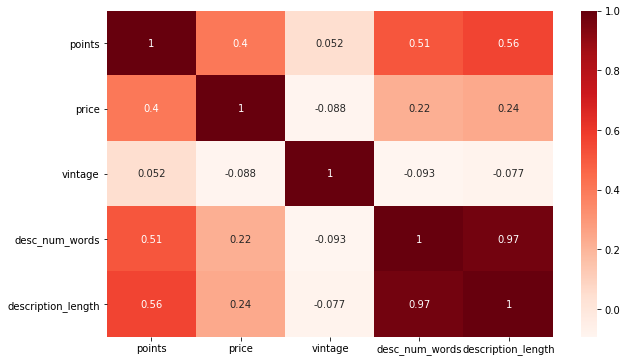

In [18]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(wine_df.corr(), annot = True,  cmap="Reds")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
heatmap.set_ylim(len(wine_df.corr()), 0);

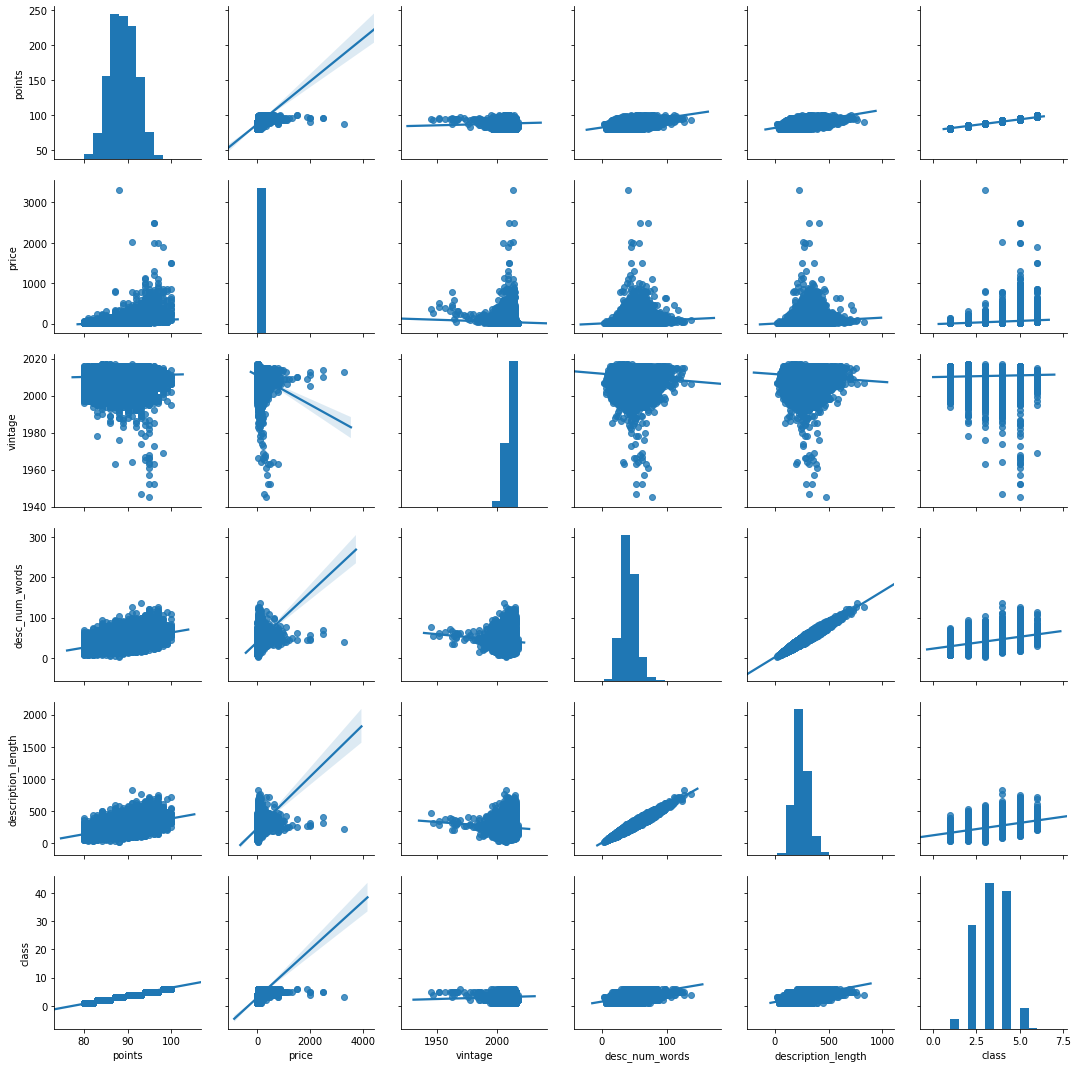

In [19]:
sns.pairplot(wine_df, kind="reg");

##  2. Wine Review Points (Rating)

The distribution of wines according to their scores appear to be normally distributed, centering around 88 points. Since the mean and the median points are almost equal at 88 points, the distribution is roughly symmetrical, as seen in the plot below.

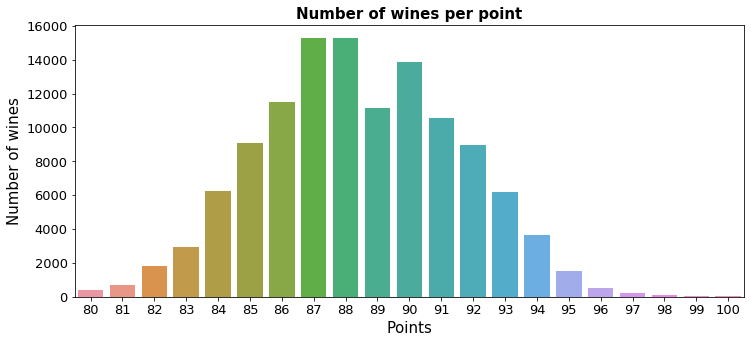

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
x_list=np.arange(80,101)
ax = sns.barplot(x=x_list, y=wine_df.groupby(['points']).count()['description'])
ax.set_title('Number of wines per point', fontweight="bold",fontsize = 15)
ax.set_ylabel('Number of wines', fontsize = 15)
ax.set_xlabel('Points', fontsize = 15)

plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13);

Splitting up the points into their different classes, we can see that the symmetrical normal distribution also carries forward since classification is based on points. In this case, most wines fall under the 'Very Good' and 'Excellent' classes, and there are very few 'Classic' wines. <br>
**Looks like the reviewers set very high expectations!**

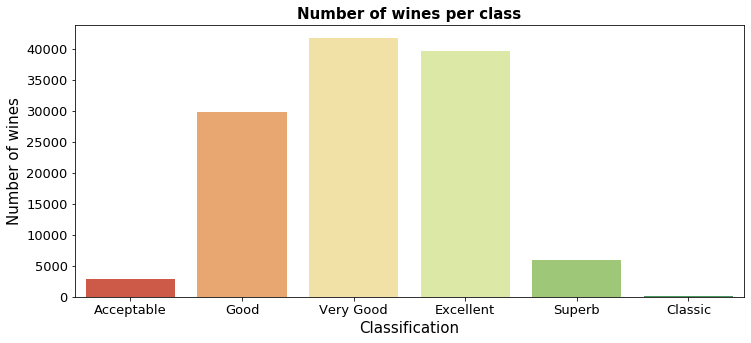

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
x_list=['Acceptable','Good','Very Good','Excellent','Superb','Classic']
ax = sns.barplot(x=x_list, y=wine_df.groupby(['class']).count()['description'], palette="RdYlGn")
ax.set_title('Number of wines per class', fontweight="bold",fontsize = 15)
ax.set_ylabel('Number of wines', fontsize = 15)
ax.set_xlabel('Classification', fontsize = 15)

plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13);

## 2. Wine Prices

For the distribution of prices, the mean is greater than the median, which indicates that the distribution is right-tailed or positively-skewed, as can be observed in the histogram below.

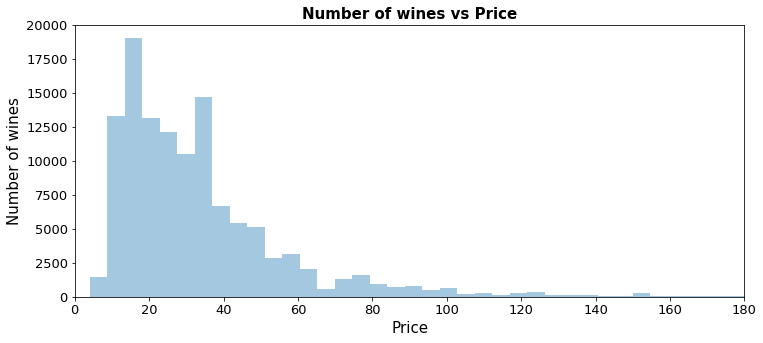

In [22]:
plt.figure(figsize=(12,5))
ax = sns.distplot(wine_df.price, kde=False, bins=700)
ax.set_title('Number of wines vs Price', fontweight="bold",fontsize = 15)
ax.set_ylabel('Number of wines', fontsize = 15)
ax.set_xlabel('Price', fontsize = 15)
plt.xlim(0, 180)

plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13);

### Relationship between Price and Points/Classification (Rating)

We can see that in general, higher classes of wine or wine with higher scores generally command higher prices, which makes sense because there is some positive correlation between points and price (correlation coefficient of 0.4 as indicated in the correlation plot). 

However, wines with the highest points (belonging to the 'Classic' group) tend to have the most variation in prices.

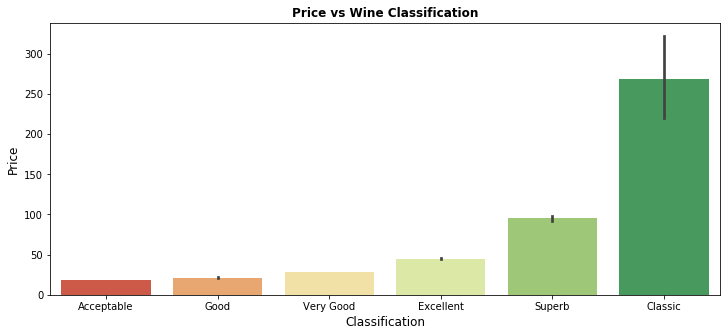

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
ax1 = sns.barplot(x='class', y='price', data=wine_df, palette="RdYlGn")

ax.set_title('Price vs Wine Classification', fontweight="bold", size=12)
ax.set_xlabel('Classification', fontsize = 12)
ax.set_ylabel('Price', fontsize = 12)

ax1.set_xticklabels(x_list)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10);

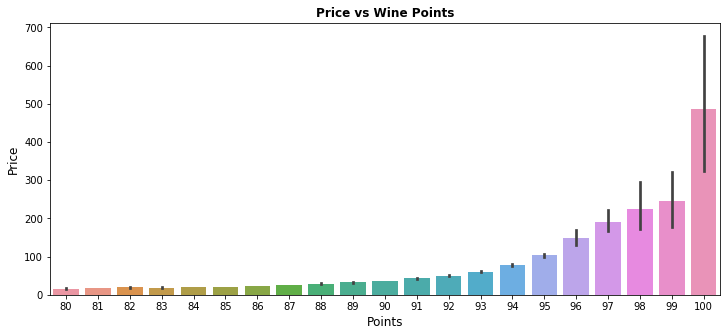

In [24]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(x='points', y='price', data=wine_df)

ax.set_title('Price vs Wine Points', fontweight="bold", size=12)
ax.set_xlabel('Points', fontsize = 12)
ax.set_ylabel('Price', fontsize = 12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10);

## 4. Wine Reviews by Country

Plotting out a bar chart for the distribution of wines for each country for the top 10 countries, we observe that the US wines form the vast majority of reviews, followed by France and Italy.

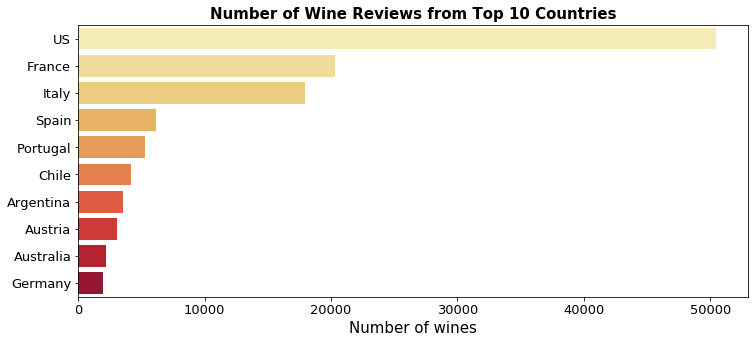

In [25]:
plt.figure(figsize=(12,5)) 
country_cnt = wine_df['country'].value_counts().to_frame()[0:10]
ax = sns.barplot(x= country_cnt['country'], y =country_cnt.index, data=country_cnt, palette='YlOrRd',orient='h')
ax.set_title('Number of Wine Reviews from Top 10 Countries', fontweight="bold", size=15)
ax.set_xlabel('Number of wines', fontsize = 15)

plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13);

### Points for Wines from Various Countries

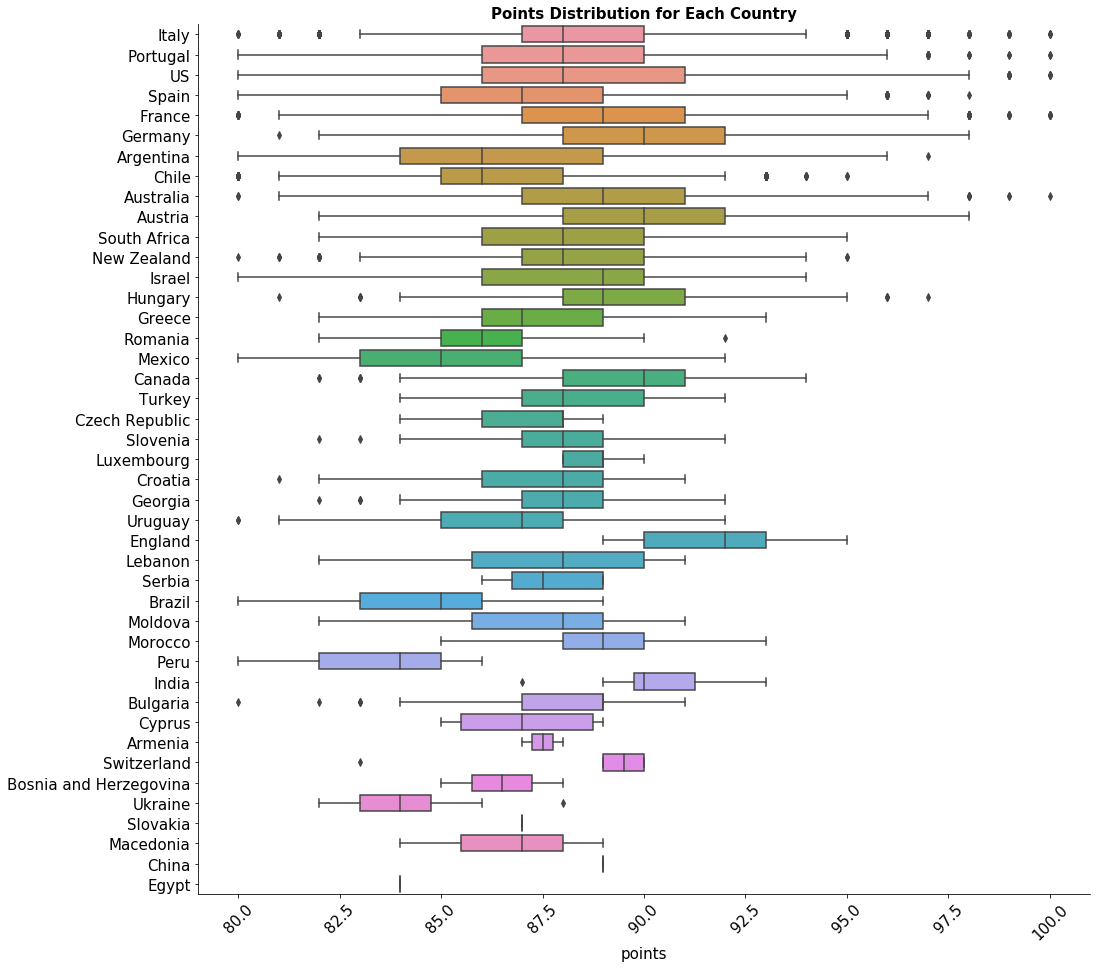

In [26]:
fig, ax = plt.subplots(figsize = (16,16))
chart = sns.boxplot(y='country',x='points', data= wine_df, ax = ax)
plt.xticks(rotation = 45)
plt.title('Points Distribution for Each Country',fontweight="bold", fontsize=15)
plt.xlabel('points',fontsize=15)
plt.ylabel("")
plt.tick_params(labelsize=15)
sns.despine(bottom=False)
plt.show()

**Countries with the best and worst wines (by average points).**

According to the reviews, countries like England, India, Austria, Germany produce the best wines, even beating traditional powerhouses like US, Italy, South Africa and Australia.

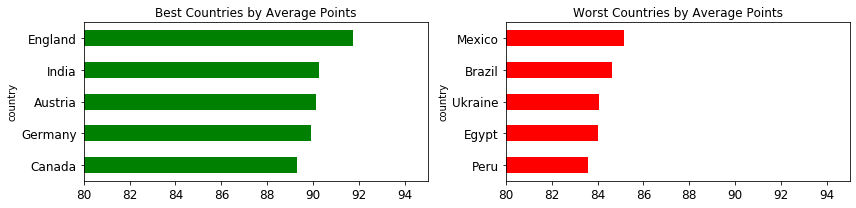

In [27]:
avg_pts = wine_df.groupby('country', as_index = False)['points'].mean()
avg_pts.set_index('country', inplace = True)
best = avg_pts.nlargest(5, 'points')
worst = avg_pts.nsmallest(5, 'points')
fig, ax = plt.subplots(1,2,figsize = (12,3))
best = best.iloc[::-1]
best.plot(kind = "barh", ax= ax[0], fontsize = 12, color='g', legend = False, title = "Best Countries by Average Points")
worst.plot(kind = "barh", ax=ax[1], fontsize = 12, color='r', legend = False, title = "Worst Countries by Average Points")
ax[0].title.set_size(12)
ax[0].set_xlim(80,95)
ax[1].title.set_size(12)
ax[1].set_xlim(80,95)
plt.tight_layout()

### Prices for Wines from Various Countries

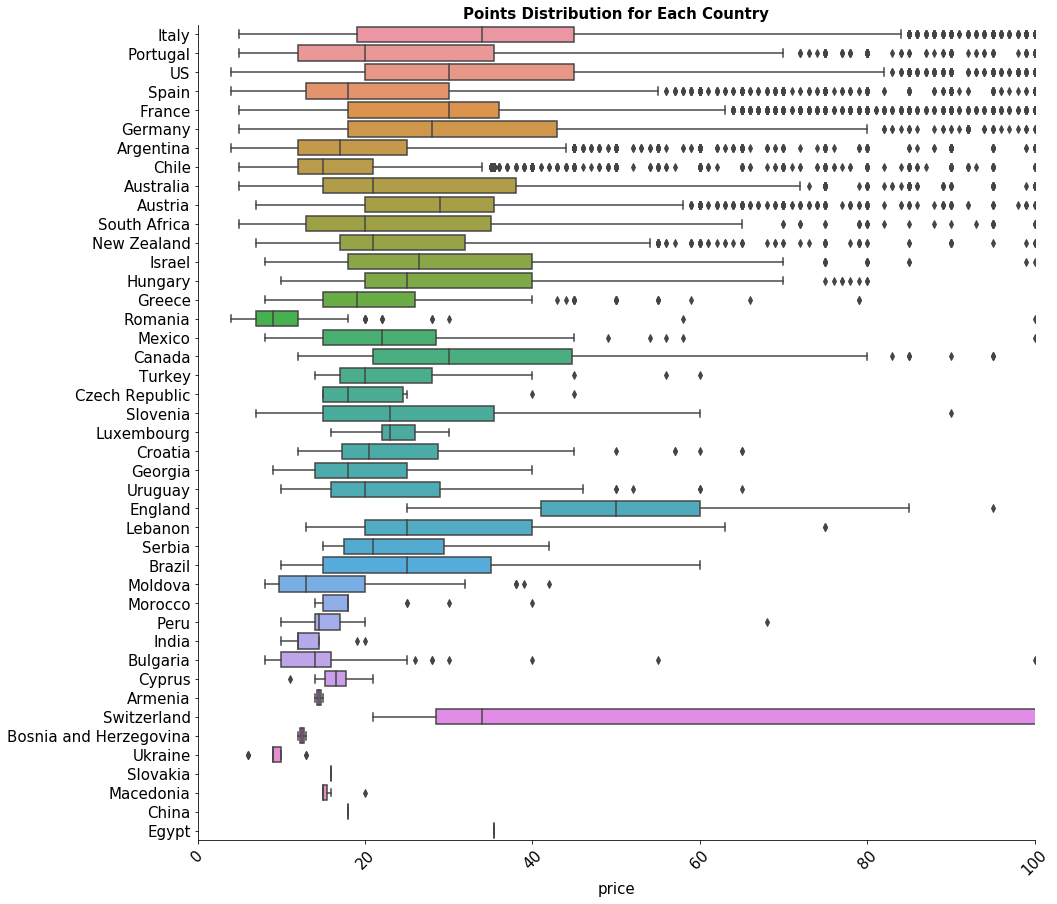

In [28]:
fig, ax = plt.subplots(figsize = (15,15))
chart = sns.boxplot(y='country',x='price', data= wine_df, ax = ax)
plt.xticks(rotation = 45)
plt.title('Points Distribution for Each Country',fontweight="bold", fontsize=15)
plt.xlabel('price',fontsize=15)
plt.ylabel("")
plt.xlim(0,100) #limit to prices within $100 due to the wide range of prices
plt.tick_params(labelsize=15)
sns.despine(bottom=False)
plt.show()

**Countries with the most expensive and cheapest wines on average (median).**

Wines from Italy, France and US generally cost more, but higher price does not always mean better quality (points). <br>
Interesting, looking at its higher points and low prices, wines from India could be the most value-for-money!

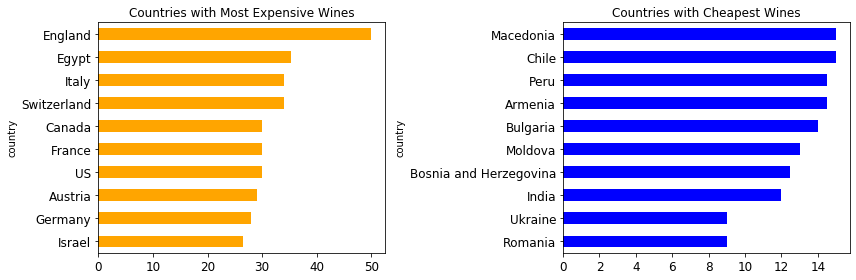

In [29]:
avg_cost = wine_df.groupby('country', as_index = False)['price'].median()
avg_cost.set_index('country', inplace = True)
expensive = avg_cost.nlargest(10, 'price')
cheap = avg_cost.nsmallest(10, 'price')
fig, ax = plt.subplots(1,2,figsize = (12,4))
expensive = expensive.iloc[::-1]
expensive.plot(kind = "barh", ax= ax[0], fontsize = 12, color='orange', legend = False, title = "Countries with Most Expensive Wines")
cheap.plot(kind = "barh", ax=ax[1], fontsize = 12, color='blue', legend = False, title = "Countries with Cheapest Wines")
ax[0].title.set_size(12)
#ax[0].set_xlim(80,95)
ax[1].title.set_size(12)
#ax[1].set_xlim(80,95)
plt.tight_layout()

## 5. Wine Varieties

### Most Common Varieties

The top 10 most common wine varieties are shown below. About 55% of all reviews are based on these 10 types of grapes.

In [30]:
#Show top 10 most common wine varieties
wine_df["variety"].value_counts().head(10)

Pinot Noir                  12277
Chardonnay                  10867
Cabernet Sauvignon           8837
Red Blend                    8239
Bordeaux-style Red Blend     6469
Riesling                     4773
Sauvignon Blanc              4574
Syrah                        3826
Rosé                         3220
Merlot                       2895
Name: variety, dtype: int64

In [31]:
(wine_df["variety"].value_counts().head(10).sum()) / (wine_df["variety"].value_counts().sum())

0.5500191740167064

### Points for Top 10 Most Common Wine Varieties

Amongst the top 10 most common varieties, Riesling, Pinot Noir, and Syrah tend to score higher points. However, Pinot Noir and Syrah cost more on average as compared to Riesling.

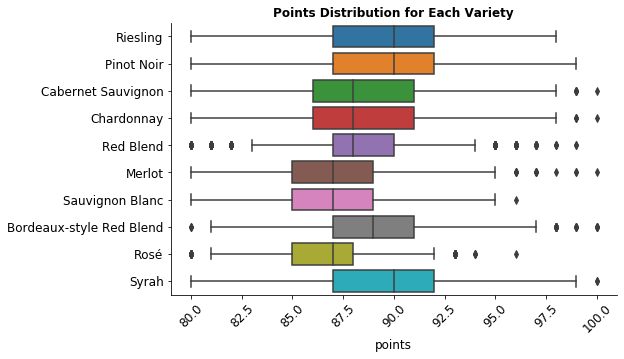

In [32]:
varieties = wine_df.groupby('variety').filter(lambda x: len(x) >= 2895)
fig, ax = plt.subplots(figsize = (8,5))
chart = sns.boxplot(y='variety',x='points', data= varieties, ax = ax)
plt.xticks(rotation = 45)
plt.title('Points Distribution for Each Variety',fontweight="bold", fontsize=12)
plt.xlabel('points',fontsize=12)
plt.ylabel("")
plt.tick_params(labelsize=12)
sns.despine(bottom=False)

### Prices for Top 10 Most Common Wine Varieties

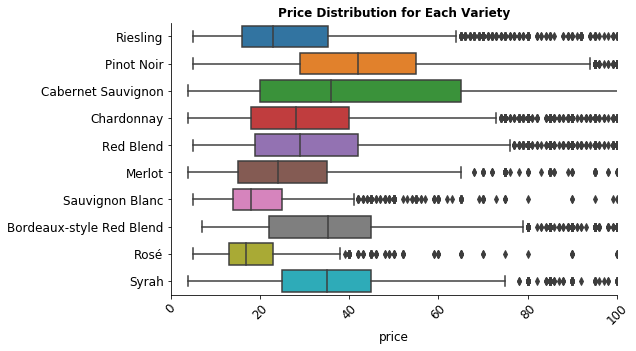

In [33]:
fig, ax = plt.subplots(figsize = (8,5))
chart = sns.boxplot(y='variety',x='price', data= varieties, ax = ax)
plt.xticks(rotation = 45)
plt.title('Price Distribution for Each Variety',fontweight="bold", fontsize=12)
plt.xlabel('price',fontsize=12)
plt.ylabel("")
plt.xlim(0,100) #limit to prices within $100 due to the wide range of prices
plt.tick_params(labelsize=12)
sns.despine(bottom=False)

## 6. Review Description Lengths

### Relationship between Description Length & Classification / Points

Revisiting the correlation plot, the correlation between description length and rating/points is 0.56. This means there is a moderate amount of positive, linear correlation between classification (which is derived from points) and description length. This can be seen in the boxplot below, where description length generally increases as the classes go higher. This relationship is also apparent through the stacked bar chart.

**It appears that reviewers tend to write a longer description if they prefer that wine!**

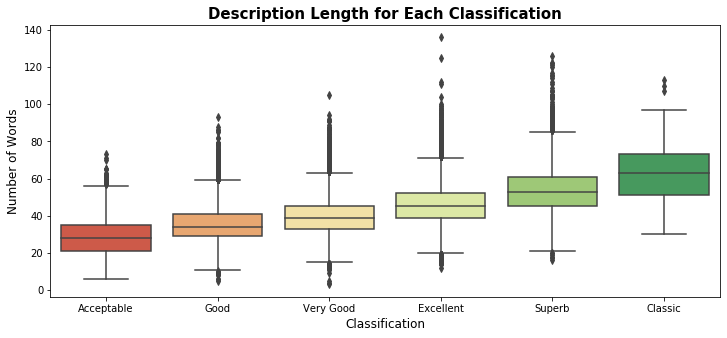

In [34]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x='class', y='desc_num_words', data= wine_df, palette="RdYlGn")

plt.xticks(np.arange(6), ('Acceptable','Good','Very Good','Excellent','Superb','Classic'), fontsize=15, rotation=0)
plt.yticks(fontsize=15)
ax.set_title('Description Length for Each Classification', fontweight="bold", size=15)
ax.set_ylabel('Number of Words', fontsize = 12)
ax.set_xlabel('Classification', fontsize = 12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10);

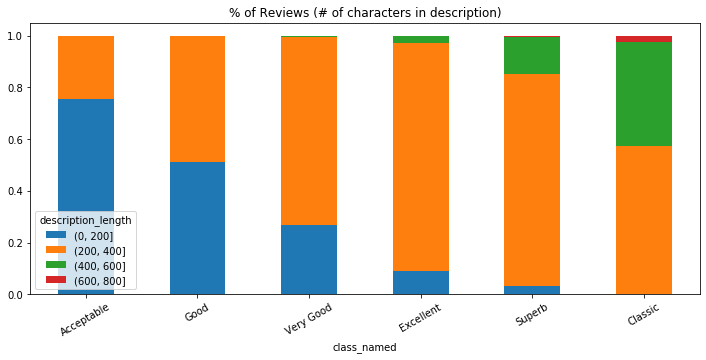

In [35]:
# generate stacked barchart to breakdown % per class
bins = list(range(0, 1000, 200))
groups = wine_df.groupby(['class_named', pd.cut(wine_df.description_length, bins)]).size().unstack()
groups = groups.div(groups.sum(axis=1), axis=0)
axes = groups.plot.bar(stacked = True, legend = True,figsize=(12,5),rot=30,title="% of Reviews (# of characters in description)")

## 7. Wine Vintage (Year)

### Relationship between Wine Vintage and Prices & Points (Rating)

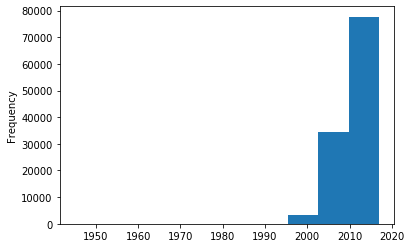

In [36]:
#wine_df.vintage.value_counts().sort_index() #see number of reviews for each vintage (year)
wine_df.vintage.plot.hist();

In [37]:
vintage_price_mean = wine_df.groupby('vintage').price.agg(['mean'])
vintage_price_max = wine_df.groupby('vintage').price.agg(['max'])
vintage_points_mean = wine_df.groupby('vintage').points.agg(['mean'])
vintage_points_max = wine_df.groupby('vintage').points.agg(['max'])

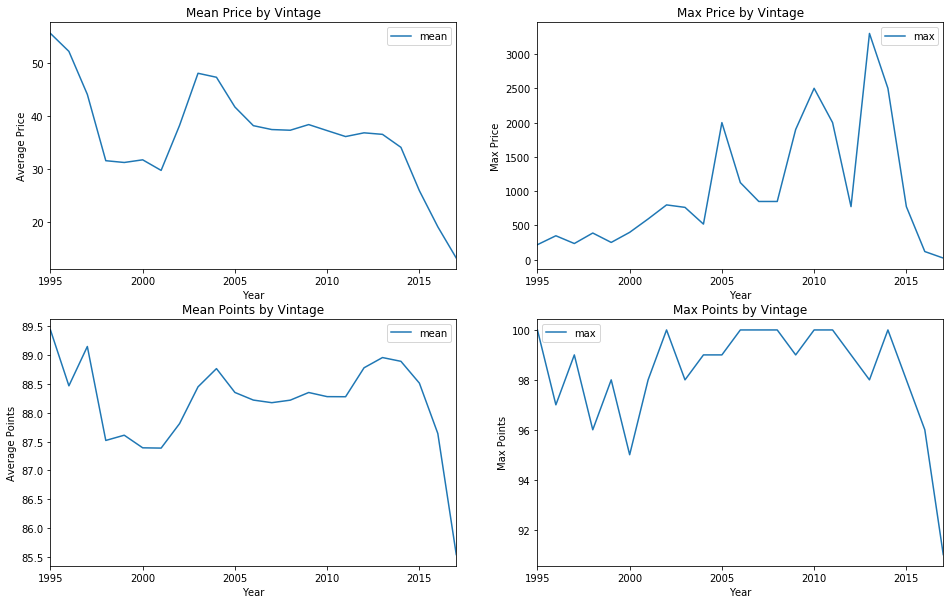

In [38]:
fig, axarr = plt.subplots(2, 2, figsize=(16, 10))

(vintage_price_mean[vintage_points_mean.index >= 1995]
 .plot
 .line(title = 'Mean Price by Vintage',ax = axarr[0][0])
 .set(xlabel = 'Year',ylabel = 'Average Price',xticks = np.arange(1995, 2018, step=5)))

(vintage_price_max[vintage_points_max.index >= 1995]
.plot
.line(title = 'Max Price by Vintage',ax = axarr[0][1])
.set(xlabel = 'Year',ylabel = 'Max Price',xticks = np.arange(1995, 2018, step=5)))

(vintage_points_mean[vintage_points_mean.index >= 1995]
.plot
.line(title = 'Mean Points by Vintage',ax = axarr[1][0])
.set(xlabel = 'Year',ylabel = 'Average Points',xticks = np.arange(1995, 2018, step=5)))

(vintage_points_max[vintage_points_max.index >= 1995]
.plot
.line(title = 'Max Points by Vintage',ax = axarr[1][1])
.set(xlabel = 'Year',ylabel = 'Max Points',xticks = np.arange(1995, 2018, step=5)));

- Focusing on vintages since 1995, we observe that average prices and points tend to vary together with vintage.
- Older wines cost more on average as compared to more recent wines (2014 - 2017), which are much cheaper.
- Recent wines tend to score lower points, although it appears that vintage has less effect on points for older wines.

# Natural Language Processing

In this section, natural language processing techniques is used to extract keyword features from the descriptions in order to build our classification and clustering models later on.

The dataset would first need to be preprocessed by tokenizing the text, which we would then be able to plot frequency distributions for commonly-used words, check for concordance and common contexts in which these words are used. We may need to run the text through a list of stop words first to remove them, as these stop words are likely unimportant when considering the meaning of the text and unable to provide significant value in the dataset. Some of the stopwords are also frequently used descriptive words within the dataset, and would take up memory and processing time if left in.

Stemming/Lemmatizing also need to be performed to reduce frequently-used words into their root form, so that they will not skew the distribution.

1. Since we have already tokenize the text previously, let's proceed to check out what are the common words used in the wine reviews.

In [39]:
all_words = [word for tokens in description_words for word in tokens]
unique_words = sorted(list(set(all_words)))
print("%s words in total from all descriptions, with %s number of unique words" % (len(all_words), len(unique_words)))

from collections import Counter
Counter(all_words).most_common(50) # count the 50 most common words

4939182 words in total from all descriptions, with 30462 number of unique words


[('and', 321404),
 ('the', 204710),
 ('a', 166369),
 ('of', 159481),
 ('with', 111464),
 ('this', 105010),
 ('is', 89574),
 ('it', 79910),
 ('wine', 74275),
 ('flavors', 58046),
 ('in', 57900),
 ('to', 51907),
 ('s', 49366),
 ('fruit', 46036),
 ('on', 41962),
 ('that', 37573),
 ('aromas', 36245),
 ('palate', 35113),
 ('finish', 32142),
 ('acidity', 32135),
 ('from', 30065),
 ('but', 29060),
 ('tannins', 28451),
 ('drink', 27879),
 ('cherry', 26916),
 ('black', 26649),
 ('ripe', 25114),
 ('are', 23844),
 ('has', 22881),
 ('for', 20232),
 ('red', 19976),
 ('by', 18997),
 ('spice', 17733),
 ('notes', 17476),
 ('an', 16923),
 ('as', 16900),
 ('its', 16687),
 ('oak', 16425),
 ('rich', 16227),
 ('fresh', 16043),
 ('dry', 15950),
 ('now', 15795),
 ('berry', 15626),
 ('nose', 15521),
 ('full', 14718),
 ('plum', 13730),
 ('soft', 12650),
 ('sweet', 12626),
 ('fruits', 12491),
 ('well', 12384)]

2. There are many stop words and other frequently-used words which may not be useful for the predictive models later.
    - We have to **remove stop words and less meaingful words** such as "wine", "drink", "taste","fruit".
    - **Change words with same meaning into their root form**

In [42]:
# Add the WordCloud stopwords to the NLTK list of stopwords and create stopword list
# nltk.download('stopwords')
stopwords_list = set(STOPWORDS)
stopwordsnltk = nltk.corpus.stopwords.words('english')
stopwords_list.update(list(stopwordsnltk))

# Update stopword list:
stopwords_list.update(["drink", "now", "wine","fruit","fruits", "fruity", "flavor", "flavors", "Flavors",  
                  "taste", "tastes", "let", "smell", "finish", "palate", "aromas","notes"])

[nltk_data] Downloading package stopwords to C:\Users\Jon
[nltk_data]     Chiang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [49]:
# Lemmatize the words in the descriptions and apply them to a new column 'description_cleaned'
# nltk.download('wordnet')
wn = WordNetLemmatizer()
description_words = description_words.apply(lambda elem: [word for word in elem if not word in stopwords_list])
description_words = description_words.apply(lambda elem: [wn.lemmatize(word) for word in elem])
description_words = description_words.apply(lambda elem: [word for word in elem if not word in stopwords_list])
wine_df['description_cleaned'] = description_words.apply(lambda elem: ' '.join(elem))

[nltk_data] Downloading package wordnet to C:\Users\Jon
[nltk_data]     Chiang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


3. The **most common words** used in descriptions:

In [50]:
all_words = [word for tokens in description_words for word in tokens]
unique_words = sorted(list(set(all_words)))
print("%s words in total from all descriptions, with %s number of unique words" % (len(all_words), len(unique_words)))
Counter(all_words).most_common(50)

2622405 words in total from all descriptions, with 27860 number of unique words


[('acidity', 32135),
 ('cherry', 30916),
 ('tannin', 30393),
 ('black', 26664),
 ('ripe', 25114),
 ('spice', 20516),
 ('red', 20204),
 ('berry', 17802),
 ('oak', 16436),
 ('rich', 16235),
 ('fresh', 16043),
 ('dry', 15994),
 ('nose', 15523),
 ('plum', 15024),
 ('full', 14718),
 ('apple', 13999),
 ('blackberry', 13951),
 ('show', 13846),
 ('blend', 12702),
 ('soft', 12650),
 ('sweet', 12628),
 ('well', 12394),
 ('offer', 12257),
 ('white', 11976),
 ('crisp', 11756),
 ('light', 11648),
 ('texture', 11526),
 ('dark', 11400),
 ('citrus', 10788),
 ('bodied', 10512),
 ('raspberry', 10230),
 ('vanilla', 10206),
 ('cabernet', 10174),
 ('hint', 10130),
 ('herb', 10050),
 ('bright', 10038),
 ('year', 9540),
 ('pepper', 9431),
 ('touch', 9249),
 ('lemon', 9113),
 ('green', 9077),
 ('juicy', 8965),
 ('good', 8923),
 ('peach', 8774),
 ('firm', 8500),
 ('give', 8421),
 ('pear', 8116),
 ('chocolate', 8058),
 ('currant', 8031),
 ('balanced', 7834)]

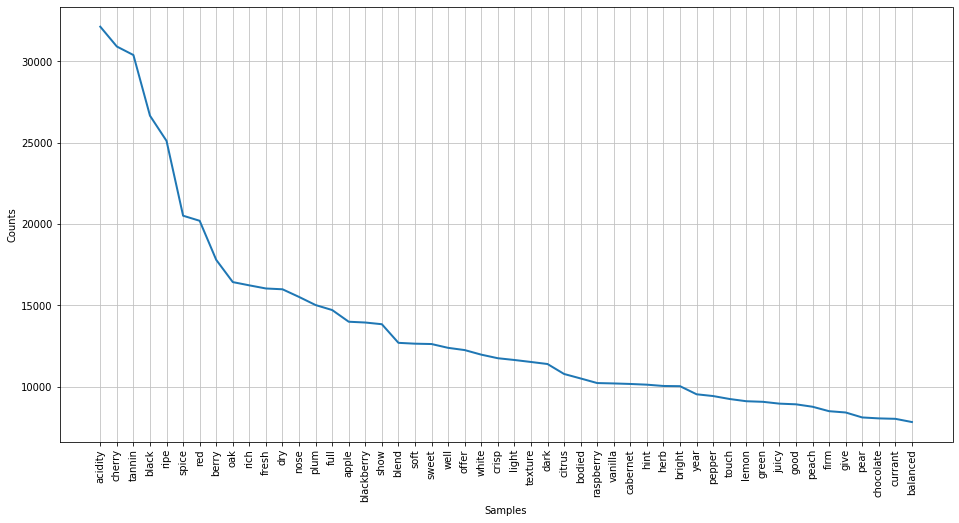

In [51]:
# plot a frequency distribution of most commonly used descriptive words after text preprocessing
fdistwords = FreqDist(all_words)
plt.figure(figsize=(16,8))
fdistwords.plot(50, cumulative=False);

4. Take a look at the top words from the descriptions for English (highest points) and Peruvian (lowest points) wines. Perhaps the reviewers enjoy fresh, crisp tastes more than heavy, roasted and earthy wines.

In [52]:
def winefreq(country):
    english_wines = wine_df[wine_df["country"] == country]
    words = (english_wines.description_cleaned.str.cat(sep=' ').split())

    rslt = pd.DataFrame(Counter(words).most_common(10),
                        columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)

In [53]:
winefreq("England")

           Frequency
Word                
apple             72
nose              42
freshness         40
lemon             34
tart              32
creamy            31
red               29
green             25
crisp             24
fresh             23


In [54]:
winefreq("Peru")

         Frequency
Word              
berry            6
plum             6
baked            6
mouth            5
heavy            5
oak              4
roasted          4
earthy           4
malbec           4
feel             4


In [55]:
winefreq("US")

            Frequency
Word                 
cherry          16297
tannin          11402
black           10983
acidity         10196
oak              9648
dry              8416
ripe             7632
blackberry       7506
show             7426
spice            7360


# Predicting Country of Origin from Wine Description

In [56]:
# Import relevant machine learning packages
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

For the analysis in this section, we will only take the **top five countries (by number of reviews)** in the wine dataset. The rest of the entries from other countries do not make up a significant portion of the dataset, so we will ignore them for the building of our models. Although the models can also work with the full set of countries, processing time will be much higher and the accuracy of our models will be lower since the features we are extracting are text-based and descriptive in nature, which means there will be a lot of overlap between each country.

In [57]:
top5_summary = wine_df.groupby('country').count().sort_values('description', ascending=False).head()
top5_summary

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,desc_num_words,description_length,class,class_named,description_cleaned
country,,,,,,,,,,,,,,,,,,
US,50448,34165,50448,50448,50448,50193,46760,34461,31744,50448,50448,50448,49520,50448,50448,50448,50448,50448
France,20351,13384,20351,20351,20351,20280,0,20093,20093,20351,20351,20351,18905,20351,20351,20351,20351,20351
Italy,17921,12787,17921,17921,17921,17899,0,9943,9943,17921,17921,17921,16946,17921,17921,17921,17921,17921
Spain,6116,4891,6116,6116,6116,6109,0,6052,6052,6116,6116,6116,5638,6116,6116,6116,6116,6116
Portugal,5256,4715,5256,5256,5256,0,0,5251,5251,5256,5256,5256,4950,5256,5256,5256,5256,5256


In [58]:
top_5_countries = {i: idx for idx, i in enumerate(top5_summary.index)} # create a dict of the top 5 countries
top5_df = wine_df[wine_df['country'].map(lambda x: x in top_5_countries)]

description_list = top5_df['description_cleaned'].tolist() # list of all descriptions for top 5 countries, feature set
country_list = [top_5_countries[i] for i in top5_df['country'].tolist()]
country_list = np.array(country_list) # list of countries, this will be our label set

We can then use **term frequency-inverse document frequency (tf-idf) transformations** to convert the text features into numerical values. Tf-idf is a form of vectorization that helps us identify the importance of a word is to the corpus by assigning a weightage value to each word.

Term Frequency is a scoring of the frequency of the word in the current document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. The term frequency is often divided by the document length to normalize.

Inverse Document Frequency is a scoring of how rare the word is across documents. The rarer the term, the higher the IDF score.

The tf-idf value rises in proportion to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust words that appear more frequently. This can help us build a Bag-of-Words model with each word in numerical representation, which we can apply machine learning techniques like clustering or classification to. A Bag-of-Words is just a way of extracting features from the text for use in machine learning, which in our case, will be the descriptive keywords for the wines from each country.

In [59]:
count_vect = CountVectorizer(stop_words=stopwordsnltk) #CountVectorizer counts frequency of a word in a document
x_train_counts = count_vect.fit_transform(description_list)

In [60]:
tfidf_transformer = TfidfTransformer() #tf-idf transformation uses the word frequency to calculate the IDF value
X_tfidf = tfidf_transformer.fit_transform(x_train_counts)

Using the below functions to extract the keywords with the highest tf-idf scores for each country, we can have an idea of the most common keywords relating to the country of origin for each wine.

In [61]:
def make_country(country_name):
    country_tmp = top5_df[top5_df['country'] == country_name]
    country_rev = " ".join(review for review in country_tmp.description)
    country_rev = "".join(c for c in country_rev if not c.isdigit()) # remove digits
    return country_rev

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

The code below prints out the tf-idf scores for each keyword, and loops through each country to print out the top keywords for each of them.

In [62]:
country_vals = [x.lower() for x in list(top_5_countries.keys())]

f = 0
for i in top_5_countries.keys():
    country_vals[f] = make_country(i)
    f += 1

feature_names=count_vect.get_feature_names()

j = 0
for cnts in country_vals:
    # get the document that we want to extract keywords from
    doc=country_vals[j]

    # generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(count_vect.transform([doc]))

    # sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    # extract only the top n; n here is 15
    keywords=extract_topn_from_vector(feature_names,sorted_items,15)

    # print the results
    print("\n***Keywords for {}***".format(list(top_5_countries.keys())[j]))
    for k in keywords:
        print("{}: {},".format(k, keywords[k]), end=" ")
    
    print()    
    j += 1


***Keywords for US***
cherry: 0.179, oak: 0.17, black: 0.167, dry: 0.146, acidity: 0.135, cabernet: 0.135, sweet: 0.128, bodied: 0.122, red: 0.118, nose: 0.118, rich: 0.117, ripe: 0.114, light: 0.11, vanilla: 0.109, blend: 0.103, 

***Keywords for France***
acidity: 0.275, ripe: 0.246, rich: 0.179, character: 0.177, crisp: 0.159, texture: 0.157, full: 0.155, wood: 0.154, red: 0.15, fresh: 0.144, well: 0.141, ready: 0.134, structure: 0.128, aging: 0.126, dry: 0.125, 

***Keywords for Italy***
cherry: 0.215, alongside: 0.198, black: 0.195, white: 0.179, spice: 0.17, berry: 0.151, delivers: 0.145, note: 0.139, bright: 0.136, red: 0.128, dried: 0.128, acidity: 0.121, leather: 0.114, ripe: 0.111, fresh: 0.11, 

***Keywords for Spain***
berry: 0.269, plum: 0.263, nose: 0.15, oak: 0.147, apple: 0.129, herbal: 0.128, blackberry: 0.124, fresh: 0.117, baked: 0.116, earthy: 0.112, black: 0.111, good: 0.109, citrus: 0.108, red: 0.105, green: 0.1, 

***Keywords for Portugal***
acidity: 0.268, ripe

If we want to visualise the dominant words in each country's description, we can replace the country in the wordcloudgen function to generate a Word Cloud for that country's wine descriptions:

In [63]:
# Create a zip object from two lists
zip_cnt_key_vals = zip(top_5_countries.keys(), country_vals)
# Create a dictionary from zip object
country_desc_dict = dict(zip_cnt_key_vals)

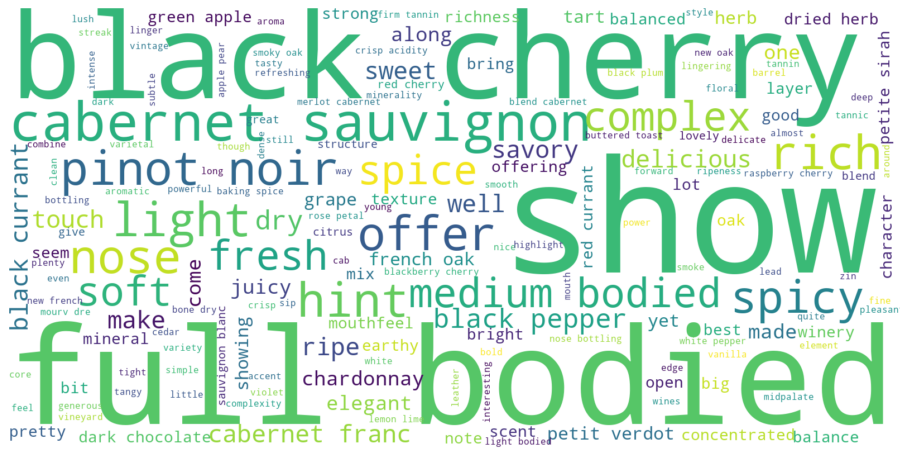

In [64]:
def wordcloudgen(country_name):
    wordcloud_arg = WordCloud(stopwords=stopwords_list, 
                              background_color="white", scale = 4).generate(country_desc_dict[country_name])
    plt.figure(figsize=(16,10))
    plt.imshow(wordcloud_arg, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Generate a word cloud image (e.g US)
wordcloud_arg = wordcloudgen('US')

## Country Classification (Supervised Learning)

In this section, various classification models, which is a form of supervised learning, are used to classify the keywords we have picked out earlier and sort them to each country. We can compare the performance for each classifier and determine which one is the most accurate and takes the fastest time to compute, hence making it suitable for use for our dataset.

We first split the corpus into training and test sets, and run it through various classifiers:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, country_list, test_size=0.3, random_state=42)

In [66]:
multinom = MultinomialNB().fit(X_train, y_train)
randforest = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)
svm = LinearSVC().fit(X_train, y_train)
ada = AdaBoostClassifier().fit(X_train, y_train)
dectree = DecisionTreeClassifier().fit(X_train, y_train)

In [67]:
fitted_models = {
  "Multinomial Naive Bayes": multinom,
  "Random Forest": randforest,
  "K-Nearest Neighbours": knn,
  "Support Vector Machine": svm,
  "Ada Boost": ada,
  "Decision Tree": dectree
}

Calculating the accuracy of every model on the test set, we can see that the linear Support Vector Machine is the most accurate out of all of them with the best runtime when predicting results. K-Nearest Neighbours also has a high accuracy but is the most resource-intensive out of all of them with the longest computation time.

Multinomial Naive Bayes also gives good accuracy with a short runtime.

In [68]:
# KNN is the most accurate out of the classifiers but it takes very long to run
for key, value in fitted_models.items():
    %time print("{} Accuracy: {}%".format(key, (accuracy_score(y_test, value.predict(X_test))*100).round(2)))

Multinomial Naive Bayes Accuracy: 85.9%
Wall time: 7.03 ms
Random Forest Accuracy: 82.17%
Wall time: 123 ms
K-Nearest Neighbours Accuracy: 88.93%
Wall time: 1min 1s
Support Vector Machine Accuracy: 93.62%
Wall time: 15.6 ms
Ada Boost Accuracy: 72.1%
Wall time: 361 ms
Decision Tree Accuracy: 75.2%
Wall time: 31.3 ms


In order to use the model we built, we can input a description of a wine into any of the models to predict which country it comes from:

In [69]:
Y1 = count_vect.transform(['This full-bodied wine inspires a pairing with foods that have a sweet cheese or butter element. \
                           It is well shaped and opulent, with loads of crushed black pepper, dried fruit and  \
                           earthy nuances.'])
Y2 = count_vect.transform(['This light wine pairs well with Chinese seafood or vegetable dishes. \
                           It has a fresh, lemon peel on the nose, which offers a smooth and crisp finish.'])
prediction1 = knn.predict(Y1) # Here we use the Knn model, but any of the models used can be substituted as well
prediction2 = svm.predict(Y2) # Here we use the SVM model, but any of the models used can be substituted as well
print(top_5_countries)
for key, value in top_5_countries.items():
    if prediction1[0] == value:
        print("[Knn Model] Predicted country is {}".format(key))

for key, value in top_5_countries.items():
    if prediction2[0] == value:
        print("[SVM Model] Predicted country is {}".format(key))

{'US': 0, 'France': 1, 'Italy': 2, 'Spain': 3, 'Portugal': 4}
[Knn Model] Predicted country is France
[SVM Model] Predicted country is France


### Tuning K-Nearest Neighbours Model

To improve our K-Nearest Neighbours model, we can perform some cross validation and loop through a range of nearest neighbours to obtain the optimal k value. This takes a long time to run as K-Nearest Neighbours is computationally expensive. This is because the model stores all the values of the distances between neighbours in memory, and scans the entire range of stored distances each time a prediction is required, resulting in high resource usage and computation time.

In [70]:
# this takes very looooooooong to run
# creating odd list of K for KNN
neighbors = list(range(1, 50, 5))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    cv_scores.append(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out

After the cross validation, we can see that the optimal number of neighbours is around 21:

The optimal number of neighbors is 21


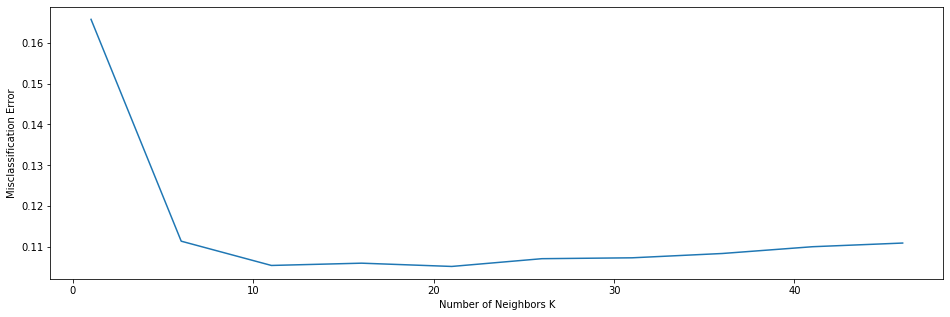

In [71]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.figure(figsize=(16,5))
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()

Running the k-nearest neighbours model again with the optimal k value, the accuracy has improved about 1%, which is not a significant amount for the computational resources needed to calculate optimal k and to fit the model.

In [72]:
knn_tuned = KNeighborsClassifier(n_neighbors=optimal_k).fit(X_train, y_train)
print("Accuracy of K-Nearest Neighbours model after tuning for optimal number of neighbours k: {}% \n".format(
    (accuracy_score(y_test, knn_tuned.predict(X_test))*100).round(2)))
print(classification_report(y_test, knn_tuned.predict(X_test)))

Accuracy of K-Nearest Neighbours model after tuning for optimal number of neighbours k: 89.75% 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     15031
           1       0.79      0.93      0.85      6172
           2       0.92      0.94      0.93      5395
           3       0.99      0.74      0.85      1820
           4       0.88      0.35      0.50      1610

    accuracy                           0.90     30028
   macro avg       0.90      0.78      0.81     30028
weighted avg       0.90      0.90      0.89     30028



From the classification report, the following metrics are calculated:
* Precision, which indicates how many of the items that we identified were relevant = TP/(TP+FP).
* Recall, which indicates how many of the relevant items that we identified = TP/(TP+FN).
* The F1-Score, which combines the precision and recall to give a single score, is defined to be the harmonic mean of the precision and recall (2 × Precision × Recall)/(Precision+Recall).

Although the precision may be high across all countries, the recall value drops across the range from the country with the highest number of wines (US), down to the last country (Portugal) in our top five country dataset. This is likewise seen in the confusion matrix below, where out of 1610 entries for Portugal, only 557 were correctly classified while the rest were falsely identified to be coming from France. 

This is expected since the dataset is heavily skewed towards the US. Even though we have taken the top five countries, the US still heavily outweighs the other four countries by sheer volume. Hence, the model is very much trained based on wine descriptions from the predominent country and may not be as good as predicting wines from a country without as much entries.

In [73]:
# function to plot a stylised confusion matrix
def plot_confusion_matrix(clf):
    plt.figure(figsize=(13,5))
    cnf_mat = pd.crosstab(y_test, clf.predict(X_test), margins=True)
    cnf_hm = sns.heatmap(cnf_mat, annot = True,  fmt='d', cmap="Greens", annot_kws={"size": 15})
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    top_5_countries_list = list(top_5_countries.keys())
    top_5_countries_list.append('All')
    cnf_hm.set_xticklabels(top_5_countries_list, fontsize=12)
    cnf_hm.set_yticklabels(top_5_countries_list, fontsize=12)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    cnf_hm.set_ylim(len(cnf_mat),0);

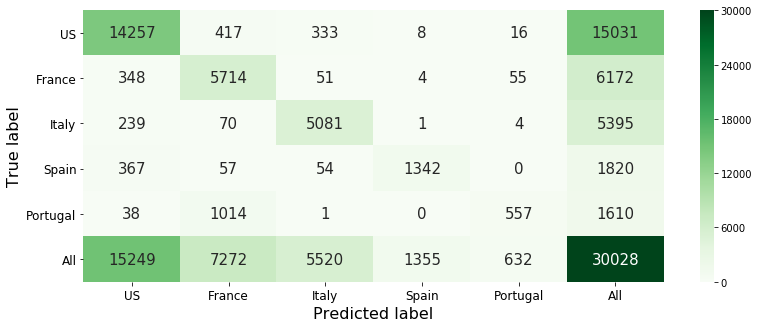

In [74]:
plot_confusion_matrix(knn_tuned)

### Tuning Random Forest Model

We can further tune the hyperparamenters for the random forest model to achieve an accuracy of 85% (an increase of 3%), which is around the same as the multinomial Naive Bayes model (without tuning), but the computational time needed to perform the grid search to optain the optimal number of trees is likewise quite substantial as well, although it does not take as long as the K-Nearest Neighbours model.

In [75]:
n_range = np.arange(1, 50, 5) 

param_dict={'n_estimators': n_range} # vary the number of trees, for each of them run the cross-validation and compute F1 score
rf2= GridSearchCV(RandomForestClassifier(), param_grid=param_dict, n_jobs=-1, cv=5, verbose=2)

rf_tuned = rf2.fit(X_train, y_train) 

y_score = rf_tuned.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   54.4s remaining:   39.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Optimal number of trees is 46 after the grid search:

In [76]:
rf2.best_params_

{'n_estimators': 46}

In [77]:
print("Accuracy of Random Forest model after tuning for optimal number of trees: {}%".format(
    (accuracy_score(y_test, rf_tuned.predict(X_test))*100).round(2)))

Accuracy of Random Forest model after tuning for optimal number of trees: 85.74%


### Tuning Linear SVC Model

In machine learning, support vector machines (SVMs) are supervised learning models with associated learning algorithms that can be used for classification and regression analysis. An SVM is a discriminative classifier formally defined by a separating hyperplane. 

Linear Kernel is used when the data is linearly separable, and can be separated using a single line. It is one of the most common kernels to be used, especially for datasets with a large number of features, such as for text classification.

LinearSVC is also similar to SVC with the parameter kernel=’linear’, but is implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and scales better to large sample sizes.

Advantages of using the linear kernel:

1. Training a SVM with a linear kernel is faster than with any other kernel, resulting in our very short fitting and training time as calculated earlier.

2. When training a SVM with a linear kernel, we only need to optimise for the C regularisation/penalty parameter. On the other hand, when training with other kernels, there is a need to optimise the γ parameter which means that performing a grid search will usually take more time.

In [78]:
n_range = np.arange(0.1, 2, 0.1) 

param_dict={'C': n_range} # vary the penalty parameter, for each of them run the cross-validation and compute F1 score
sv1= GridSearchCV(LinearSVC(), param_grid=param_dict, n_jobs=-1, cv=5, verbose=2)

svm_tuned = sv1.fit(X_train, y_train) 

y_score = svm_tuned.predict(X_test)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   14.2s finished


In [79]:
sv1.best_params_

{'C': 0.9}

In [80]:
print("Accuracy of Linear SVC model after tuning for optimal penalty parameter C: {}% \n".format(
    (accuracy_score(y_test, svm_tuned.predict(X_test))*100).round(2)))
print(classification_report(y_test, svm_tuned.predict(X_test)))

Accuracy of Linear SVC model after tuning for optimal penalty parameter C: 93.61% 

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     15031
           1       0.86      0.92      0.89      6172
           2       0.98      0.96      0.97      5395
           3       0.97      0.92      0.95      1820
           4       0.88      0.51      0.65      1610

    accuracy                           0.94     30028
   macro avg       0.93      0.86      0.88     30028
weighted avg       0.94      0.94      0.93     30028



Just like what we saw previously in the K-Nearest-Neighbours model, the recall value is the lowest for Portugal, and it has a proportionally high number of misclassified wines. However, this recall value is improved from the previous model, and accordingly, the number of correctly predicted wines from Portugal has increased to 829 from 557.

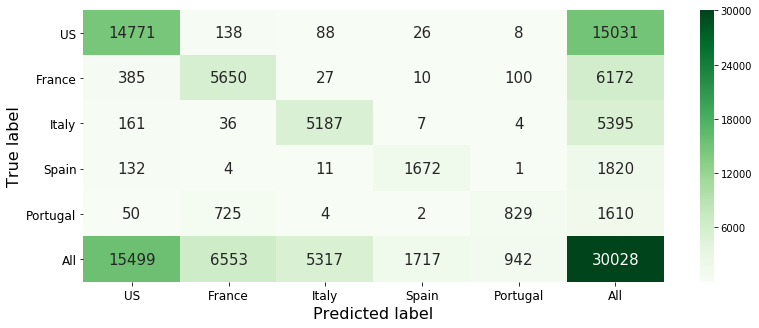

In [81]:
plot_confusion_matrix(svm_tuned)

Even though we have tried to adjust for the best C value through the cross-validation grid search, it seems that the tuned model doesn't fare any better than the untuned SVC model we used initially. Nevertheless, this shows the high accuracy and speed when using linear SVC, along with the straightforward hyperparameter tuning, making it a good model for text classification.

We can visualise the decision boundaries for the linear SVC model by decomposing the X_train sparse matrix to lower dimensions and plotting the hyperplanes to give us a sense of how the model segments the data.

In [82]:
from sklearn.decomposition import TruncatedSVD
trun = TruncatedSVD(n_components=2).fit(X_train)
X_train_2d = trun.transform(X_train)

In [83]:
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1

In [84]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [85]:
clf = svm.fit(X_train_2d, y_train)

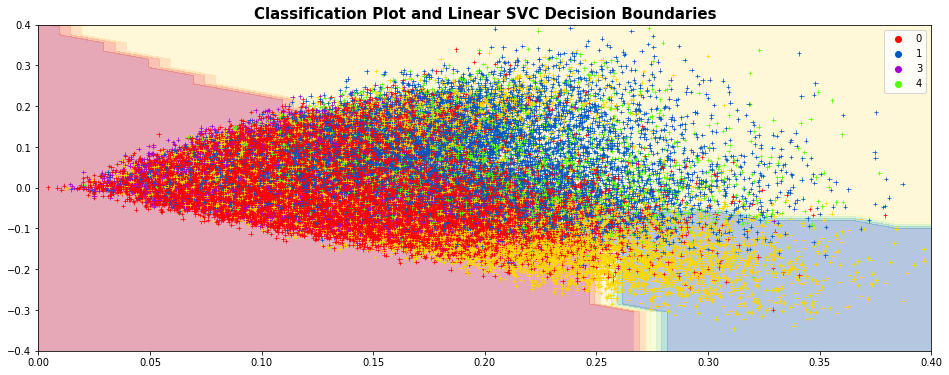

In [86]:
fig, ax = plt.subplots(figsize=(16,6))
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting
X0, X1 = X_train_2d[:, 0], X_train_2d[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.Spectral, alpha=0.4)
ax = sns.scatterplot(X0, X1, hue=y_train, marker="+", s=20, palette='prism', edgecolors='k')
plt.xlim(0, 0.4)
plt.ylim(-0.4, 0.4)
ax.set_title('Classification Plot and Linear SVC Decision Boundaries', fontweight="bold", size=15);
#ax.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

### Tuning Multinomial Naive Bayes Model

In contrast to K-Nearest Neighbours, the Multinomial Naive Bayes model is very quick with a decent accuracy score of around 86%, making it a good candidate along with Linear SVC for quickly classifying large text datasets.

Due to its speed, Naive Bayes models can be used for real-time prediction even on large datasets, where it is typically used on e-mail spam filtering since it fulfils the criteria. Using a probabilistic estimation route and generating probabilities for each class, it assumes conditional independence (which is why it is called 'Naive') between the features and uses a maximum likelihood hypothesis.  

We can further tune the model by varying the alpha hyperparameter and running it through a cross-validation grid search to determine the best alpha for our model.

In [87]:
n_range = np.arange(0, 1, 0.01) 

param_dict={'alpha': n_range} # vary the alpha, for each of them run the cross-validation and compute F1 score
rf1= GridSearchCV(MultinomialNB(), param_grid=param_dict, n_jobs=-1, cv=5, verbose=2)

multinom_tuned = rf1.fit(X_train, y_train) 

y_score = multinom_tuned.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.0s finished


In [88]:
rf1.best_params_ # display the optimum alpha level after tuning

{'alpha': 0.05}

In [89]:
print("Accuracy of Multinomial Naive Bayes model after tuning for optimal alpha level: {}%".format(
    (accuracy_score(y_test, multinom_tuned.predict(X_test))*100).round(2)))

Accuracy of Multinomial Naive Bayes model after tuning for optimal alpha level: 91.82%


We can see that this model has a much faster computational time as compared to both Random Forest and K-Nearest Neighbours, finishing the hyperparameter search in a matter of seconds as compared to the much longer time the other two models require. The accuracy we achieve from this model after tuning is also the second highest after SVM at close to 92% (compared to K-Nearest Neighbours' 90% and Random Forest's 85% after tuning), which makes Multinomial Naive Bayes an ideal classifier for very large datasets due to its speed and accuracy, particularly after tuning.

In [90]:
print(classification_report(y_test, multinom_tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     15031
           1       0.86      0.87      0.86      6172
           2       0.99      0.93      0.96      5395
           3       0.98      0.85      0.91      1820
           4       0.96      0.44      0.60      1610

    accuracy                           0.92     30028
   macro avg       0.94      0.82      0.86     30028
weighted avg       0.92      0.92      0.91     30028



Just like what we saw in our previous classification reports and confusion matrices, recall value is generally not very good with countries with lower wine production (Portugal) compared to the top wine-producing countries. This model also has a lower recall value as compared to Linear SVC.

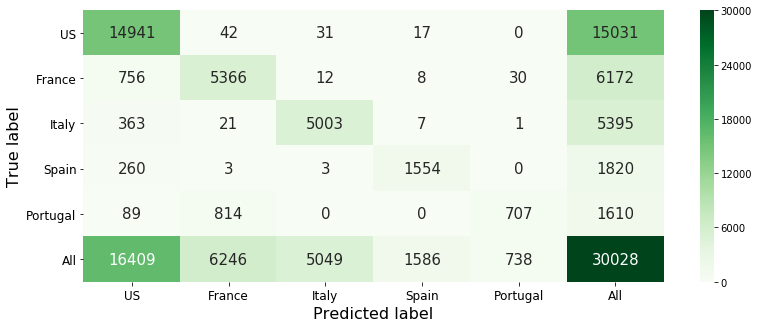

In [91]:
plot_confusion_matrix(multinom_tuned)

### Validating Tuned Models

In order to ascertain the accuracy of our tuned models and to check if we have overfitted the models, we can run the trained models through a validation set. This validation set is separate from the wine_df dataset that we used for the initial analyses, and so it is independent from our original dataset.

In [92]:
validation_df = pd.read_csv("wine/winemag-data_first150k.csv", index_col=0)
validation_df.dropna() # remove null entries in validation set
validation_df = validation_df.drop_duplicates('description') # remove duplicates in validation set

Just like our original dataset, we pick only the top 5 wine-producing countries in the validation set. These countries are however the ones we have picked out earier in the original data.

In [93]:
top5_val_df = validation_df[validation_df['country'].map(lambda x: x in top_5_countries)]
top5_val_df = top5_val_df.reset_index(drop=True)
description_val_list = validation_df['description'].tolist()

Running the descriptions in the validation set through a loop to get the predicted country and checking if the prediction is correct, we can get a further measure of the accuracy of our model.

In [94]:
tuned_models = {
  "Multinomial Naive Bayes": multinom_tuned,
  "Random Forest": rf_tuned,
  "K-Nearest Neighbours": knn_tuned,
  "Support Vector Machine": svm_tuned
}

In [95]:
def validate_tuned_models(clf_tuned):
    i = 0
    correct_pred = 0

    for row in top5_val_df.iterrows():
        Y = count_vect.transform([top5_val_df.description[i]])
        prediction = clf_tuned.predict(Y) 

        for key, value in top_5_countries.items():
            if prediction[0] == value:
                if key == top5_val_df.country[i]:
                    correct_pred += 1
        i += 1 
        
    print('   Number of correct predictions is {} out of {}, accuracy is {}%'.
        format(correct_pred, top5_val_df.description.count(), round(correct_pred/top5_val_df.description.count()*100, 2)))

Hence, it looks like our tuned models perform decently well even on a completely different dataset, which further ascertains the usability and accuracy of our models. Multinomial Naive Bayes and Linear SVC performed the best out of all the trained models, in terms of model accuracy and runtime. In contrast, we can also further ascertain that K-Nearest Neighbours has the longest runtime while having the worst accuracy, and thus is not a recommended classifier for our large wine dataset.

In [96]:
for key, value in tuned_models.items():
    print('For Tuned {} Model:'.format(key))
    %time validate_tuned_models(value)

For Tuned Multinomial Naive Bayes Model:
   Number of correct predictions is 71507 out of 78780, accuracy is 90.77%
Wall time: 28 s
For Tuned Random Forest Model:
   Number of correct predictions is 65164 out of 78780, accuracy is 82.72%
Wall time: 2min 57s
For Tuned K-Nearest Neighbours Model:
   Number of correct predictions is 62774 out of 78780, accuracy is 79.68%
Wall time: 34min 1s
For Tuned Support Vector Machine Model:
   Number of correct predictions is 69510 out of 78780, accuracy is 88.23%
Wall time: 16.6 s


### Conclusions after model tuning and validation

We can see that after tuning, our Multinomial Naive Bayes model's accuracy improved significantly, closely matching Linear SVC's accuracy of 93%. Further tuning doesn't seem to improve the Linear SVC model's accuracy. Recall value is also the best for Linear SVC, followed by Multinomial Naive Bayes and lastly, K-Nearest Neighbours. Hence, Linear SVC is the best-performing classifier out of what we have compared with.

Both the tuned Multinomial Naive Bayes and the Linear SVC model would be good models for text classification in our wine dataset, as they can predict the country with high accuracy with a good runtime based on the wine description. Both also fared well on a different dataset, and are able to achieve high accuracy scores.

### Neural Net Model 

Neural networks are a relatively new machine learning technique which creates computational networks vaguely inspired by biological neurons in the human brain. They consist of neurons or nodes which are connected like so:

<img src="wine/ANNmodel.png"
     alt="Rating Scale"
     width="500" />

Feature vectors (which in this case are our tf-idf transformed descriptive words for each country) are fed into a set of input neurons and the values are then fed forward to a hidden layer. At each connection, we feed the value forward, while the value is multiplied by a weight and a bias is added to it. This happens at every connection and at the end the values reach an output layer with one or more output nodes. The activation function will decide if a paricular neuron is 'fired' or not, just like in a brain.

Deep learning has been used extensively in natural language processing (NLP) because it is well suited for learning the complex underlying structure of a sentence and semantic proximity of various words.

We use Keras as it is a deep learning API which is capable of running on top of Tensorflow (Google), Theano or CNTK (Microsoft). Keras does not handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialised, well-optimised tensor library to do so as its backend engine. Since the lower-level operations are handled at the backend, Keras offers a relatively higher-level API which is very user-friendly to implement.

In [97]:
# import necessary Keras libraries
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

Using TensorFlow backend.


First, we input the number features and create the layers of the neural network. In our simple model, we eskew the hidden layers and proceed directly to an output layer. However, in most cases, a hidden layer of two nodes would usually suffice. 

Usually, the number of input nodes has to match the number of features. As our text dataset is very large with over 20,000 features, we will use an arbitrary number of 10 input nodes. The output has to be 5 nodes because we are predicting the top 5 countries.

In [98]:
input_dim = X_train.shape[1]  # Number of features
print("Number of features = {}".format(input_dim))
nn_model = Sequential()
nn_model.add(layers.Dense(10, input_dim=input_dim, activation='relu')) # 10 input nodes, relu activation function
nn_model.add(layers.Dense(5, activation='softmax')) # 5 output nodes, softmax for multiclass

Number of features = 24940





In [99]:
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                249410    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 249,465
Trainable params: 249,465
Non-trainable params: 0
_________________________________________________________________


The training set is then fitted to the neural network model for 10 epoches with a batch size of 10. 

Neural networks are trained using gradient descent where the estimate of the error used to update the weights is calculated based on a subset of the training dataset.

The number of examples from the training dataset used in the estimate of the error gradient is called the batch size and is an important hyperparameter that influences the dynamics of the learning algorithm. While it is possible to use grid search to calculate the optimal hyperparameters such as batch size and hidden layers, it will be very computationally taxing to do so.

Smaller batch sizes are used for two main reasons:

* They are noisy, offering a regularizing effect and lower generalization error.
* It is easier to fit one batch worth of training data in memory (i.e. when using a GPU).

Batch size is often set at something small, and is not tuned by the practitioner.

In [100]:
history = nn_model.fit(X_train, y_train, epochs=10, verbose=True, validation_data=(X_test, y_test), batch_size=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 70064 samples, validate on 30028 samples
Epoch 1/10





70064/70064 [==============================] - 36s 510us/step - loss: 0.3646 - acc: 0.8778 - val_loss: 0.1950 - val_acc: 0.9328
Epoch 2/10
70064/70064 [==============================] - 36s 512us/step - loss: 0.1472 - acc: 0.9484 - val_loss: 0.1757 - val_acc: 0.9369
Epoch 3/10
70064/70064 [==============================] - 36s 511us/step - loss: 0.1153 - acc: 0.9585 - val_loss: 0.1774 - val_acc: 0.9361
Epoch 4/10
70064/70064 [==============================] - 37s 521us/step - loss: 0.0981 - acc: 0.9640 - val_loss: 0.1845 - val_acc: 0.9371
Epoch 5/10
70064/70064 [==============================] - 36s 514us/step - loss: 0.0862 - acc: 0.9679 - val_loss: 0.1915 - val_acc: 0.9341
Epoch 6/10
70064/70064 [==============================] - 36s 513us/step - loss: 0.0773 - acc: 0.9714 - val_loss: 0.2026 - val_acc: 0.9339
Epoch 7/10
700

In [101]:
results = nn_model.evaluate(X_test, y_test, batch_size=10, verbose=False)
print("Validation Loss: {}%, Validation Accuracy: {}%".format((results[0]*100).round(2), (results[1]*100).round(2)))

Validation Loss: 24.87%, Validation Accuracy: 92.71%


In [102]:
print(classification_report(y_test, nn_model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     15031
           1       0.87      0.87      0.87      6172
           2       0.96      0.96      0.96      5395
           3       0.96      0.92      0.94      1820
           4       0.68      0.62      0.65      1610

    accuracy                           0.93     30028
   macro avg       0.89      0.87      0.88     30028
weighted avg       0.93      0.93      0.93     30028



The trained neural net model has similar levels of performance as our Linear SVC model, and arguably performed better for countries with smaller wine production, since the recall for Portugal using the trained neural net is around 0.62, which is better than that of Linear SVC, which was 0.51. This is also further reflected in the increased number of correctly predicted labels for Portugal when using the neural net.

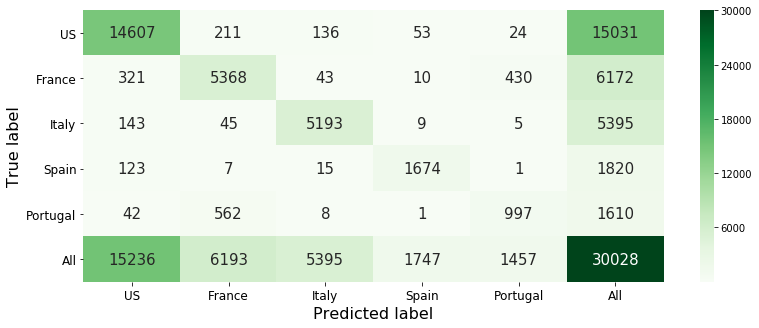

In [103]:
plt.figure(figsize=(13,5))
cnf_mat = pd.crosstab(y_test, nn_model.predict_classes(X_test), margins=True)
cnf_hm = sns.heatmap(cnf_mat, annot = True,  fmt='d', cmap="Greens", annot_kws={"size": 15})
plt.xticks(rotation=0)
plt.yticks(rotation=0)
top_5_countries_list = list(top_5_countries.keys())
top_5_countries_list.append('All')
cnf_hm.set_xticklabels(top_5_countries_list, fontsize=12)
cnf_hm.set_yticklabels(top_5_countries_list, fontsize=12)
plt.ylabel('True label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
cnf_hm.set_ylim(len(cnf_mat),0);

After training our model for 10 epochs, we can see that the accuracy obtained from the neural network compares well with the other classical machine learning models we tested. We could further tune for hyperparameters such as the number of hidden layers but for this case our simple model is performing very well on its own.

Plotting both accuracy and loss charts, we see that when we ran the model for 10 epochs, the model tends to overfit as the training accuracy approaches 100% and the validation loss increases at more than 2 or 3 epoches. Validation accuracy also drops above that threshold.

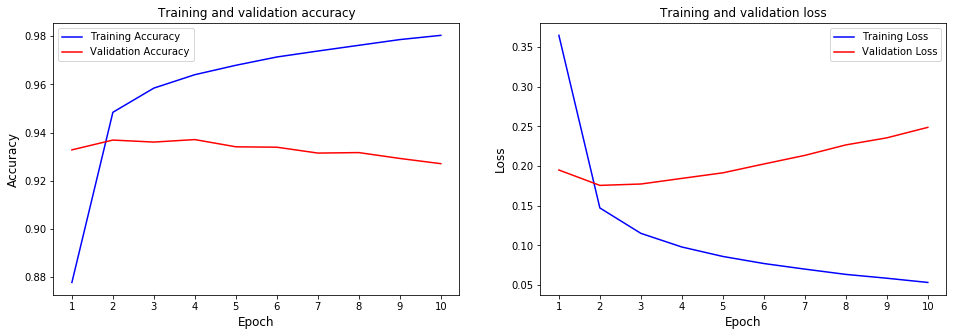

In [104]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(x, acc, 'b', label='Training Accuracy')
plt.plot(x, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.legend()
plt.subplot(122)
plt.plot(x, loss, 'b', label='Training Loss')
plt.plot(x, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.legend();

As with the classical machine learning models, we can use the predict_classes method in Keras to predict the country of origin based on the wine description.

In [105]:
Y = count_vect.transform(['Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and,  \
                           in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey \
                           acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.'])
prediction = nn_model.predict_classes(Y) # predict countries using Keras neural net
for key, value in top_5_countries.items():
    if prediction[0] == value:
        print("Predicted country is {}".format(key))

Predicted country is Spain


Hence, we can likewise calculate the accuracy of our model on the independent validation set, just like before.

In [106]:
%%time
i = 0
correct_pred = 0

for row in top5_val_df.iterrows():
    Y = count_vect.transform([top5_val_df.description[i]])
    prediction = nn_model.predict_classes(Y) 

    for key, value in top_5_countries.items():
        if prediction[0] == value:
            if key == top5_val_df.country[i]:
                correct_pred += 1
    i += 1 
    
print('Number of correct predictions is {} out of {}, accuracy is {}%'.
    format(correct_pred, top5_val_df.description.count(), round(correct_pred/top5_val_df.description.count()*100, 2)))

Number of correct predictions is 72043 out of 78780, accuracy is 91.45%
Wall time: 51 s


It is therefore evident that our neural net model has a competitive accuracy as with the classical methods used earlier. In fact, it achieved the highest score out of all of the models, with a comparatively fast runtime. Hence, it can be used alongside our more traditional machine learning models like Linear SVC or Naive Bayes for text classification.

# Sentiment Analysis

Textblob is a pre-trained sentiment analysis package that is capable of providing polarity and subjectivity scores for a given string. It is also built upon NLTK, and can also be used to perform natural language processing techniques such as tokenization and finding N-grams. 

Within TextBlob, Polarity is the measure of positive or negative sentiment within the text (ranges from -1 to 1) while Subjectivity measures how factual or subjective the text is (ranges from 0 to 1 with 0 being completely factual and 1 being completely subjective).

In [107]:
# import the TextBlob library
from textblob import TextBlob

Run the descriptions through TextBlob and create polarity and subjectivity columns for each wine review:

In [108]:
wine_df['polarity'] = [TextBlob(desc).sentiment.polarity for desc in wine_df.description_cleaned]
wine_df['subjectivity'] = [TextBlob(desc).sentiment.subjectivity for desc in wine_df.description_cleaned]

With these two new numerical columns, we can plot a new correlation plot to see if there exists any correlation between polarity, subjectivity, points and price. 

It seems that, from the low scores between the four features mentioned above, there is little to no correlation between the four. This means that using either polarity or subjectivity would not be a good estimate or predictor of either price and wine rating.

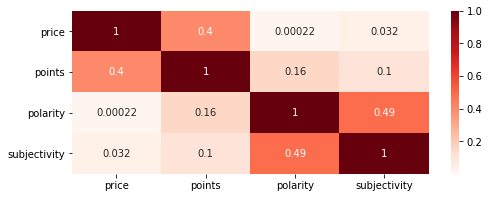

In [109]:
plt.figure(figsize=(8,3))
heatmap = sns.heatmap(wine_df[['price','points','polarity','subjectivity']].corr(), annot = True,  cmap="Reds")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
heatmap.set_ylim(len(wine_df[['price','points','polarity','subjectivity']].corr()), 0);

This lack of relationship between polarity/subjectivity and points/price can be seen below. By sorting the dataframe according to polarity, we can see that for what was classified a very negative review turns out to be a wine with a 'Very Good' classification. This means that this pre-trained model is not very effective in determining if a review is truly negative or not. It could be due to the fact that the reviews are all already taken from WineMag having already a decent score of 80 to begin with, or that the model does not perform well for these type of reviews where the language may be more nuanced or purely descriptive in nature.

In [110]:
wine_df[['price','points','class_named','polarity','subjectivity']].sort_values('polarity',).head(20)

,price,points,class_named,polarity,subjectivity
122599,25.0,89,Very Good,-0.800000,1.000000
14720,8.0,82,Acceptable,-0.700000,0.666667
108636,10.0,81,Acceptable,-0.666667,0.833333
51465,42.0,84,Good,-0.666667,1.000000
56514,30.0,82,Acceptable,-0.600000,1.000000
12708,13.0,84,Good,-0.600000,1.000000
56179,10.0,81,Acceptable,-0.600000,1.000000
60481,38.0,88,Very Good,-0.600000,0.800000
1994,18.0,84,Good,-0.600000,1.000000
124038,16.0,83,Good,-0.600000,1.000000


Furthermore, from the 'subjectivity' column below, there are some reviews with low subjectivity or even 0 subjectivity - which means that the model thinks that they are completely factual. This is most certainly untrue as the descriptions are all based on opinions. Thus, the model may be confused by the language within each description and is unable to determine if a review is factual or not. If the model was to perform as it is hoped, all the reviews should be receiving a high subjectivity score since they are all opinion-based.

In [111]:
wine_df.describe()

,points,price,vintage,desc_num_words,description_length,polarity,subjectivity
count,119955.000000,119955.000000,115526.000000,119955.000000,119955.000000,119955.000000,119955.000000
mean,88.442291,35.602323,2010.589244,41.175291,242.815939,0.153348,0.503246
std,3.093029,40.608325,3.665845,11.320133,67.146799,0.169596,0.145588
min,80.000000,4.000000,1945.000000,3.000000,20.000000,-0.800000,0.000000
25%,86.000000,18.000000,2009.000000,33.000000,197.000000,0.038542,0.414167
50%,88.000000,28.000000,2011.000000,40.000000,237.000000,0.150000,0.502083
75%,91.000000,40.000000,2013.000000,48.000000,283.000000,0.264286,0.596667
max,100.000000,3300.000000,2017.000000,136.000000,829.000000,1.000000,1.000000


In the below example we can see that the model has misinterpreted the description for this particular bottle of wine as having a high negative polarity value, but it is obvious by reading the review that it is more descriptive in nature instead.

In [112]:
print(wine_df.description[122599])
print()
ts = TextBlob(wine_df.description_cleaned[122599]).sentiment
print('Polarity value of description: {:.2f}.'.format(ts.polarity))
print('Subjectivity value of description: {:.2f}.'.format(ts.subjectivity))

touches of soy  cedar and smoked meat enhance the base of blueberry on the nose of this bottling from a vineyard in the geographic heart of the santa ynez valley  mocha and blackberry flavors show on the sip  where an even keeled acidity holds it all together 

Polarity value of description: -0.80.
Subjectivity value of description: 1.00.


# Predicting Price using Linear Regression Model

We will use **country, description length, points and vintage as features** to train a regression model for prediction of wine price. <br> We tried out different models: **linear , lasso and ridge regression**.

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score

In [114]:
#99% of wines cost less than 150 dollars
wine_df['price'].quantile(.99)

150.0

In [115]:
wine_df_price = wine_df[wine_df.price < 150]

In [116]:
X = wine_df_price[['country','points','description_length','vintage']]
y = wine_df_price.price.astype(float)

In [117]:
points_ = X.points.values
length_ = X.description_length.values
countries_ = pd.get_dummies(X.country)
vintage_ = pd.get_dummies(X.vintage)
X = np.hstack((vintage_,countries_,length_[:,None],points_[:,None]))

In [118]:
#training and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [119]:
linear_m = linear_model.LinearRegression().fit(X_train, y_train)
lasso_m = linear_model.Lasso(alpha = 0.5).fit(X_train, y_train) #l1 regularization
ridge_m = linear_model.Ridge(alpha = 0.5).fit(X_train, y_train) #l2 regularization

In [120]:
fitted_models = {
  "Linear": linear_m,
  "Lasso": lasso_m,
  "Ridge": ridge_m,
}

To gauge the accurracy of the model, we will look at mean squared error (the smaller the better), and explained variance score (closer to 1.0 is better).

In [121]:
for key, value in fitted_models.items():
    y_pred = value.predict(X_test)
    print("Model: ", key)
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print('Variance score: %.2f' % r2_score(y_test, y_pred))

Model:  Linear
Mean squared error: 312.91
Variance score: 0.33
Model:  Lasso
Mean squared error: 332.78
Variance score: 0.29
Model:  Ridge
Mean squared error: 312.87
Variance score: 0.33


In [122]:
# compare predicted prices against actual price using Ridge Regression model
ridge_pred = ridge_m.predict(X_test)
actual_vs_pred = np.vstack((ridge_pred, y_test))
price_df = pd.DataFrame(actual_vs_pred).transpose()
price_df.columns = ["Predicted", "Actual"]
price_df.sample(15)

,Predicted,Actual
33011,35.216983,14.00
9371,37.053021,28.00
5477,30.509008,60.00
3317,22.029498,8.00
15174,14.695804,13.00
28038,29.289410,19.00
11242,26.913132,15.00
2445,28.497051,15.00
24037,23.089044,39.00
14011,41.075434,22.00


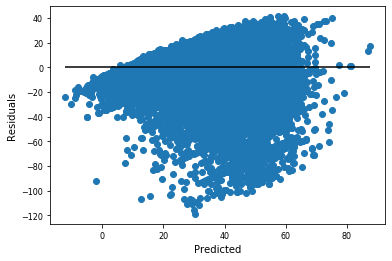

In [123]:
plt.scatter(ridge_pred, ridge_pred - y_test)
plt.hlines(y= 0, xmin = min(ridge_pred), xmax = max(ridge_pred))
plt.ylabel("Residuals", fontsize = 10)
plt.xlabel("Predicted", fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8);

Looking at the residual plot above, it seems that it is more difficult to get accurate predictions for higher-priced wines. The regression model also tends to underestimate the predicted prices.

# Predicting Class (Rating) using Random Forest Classifier

The goal is to see if we can **predict a wine's class using features such as description text, description length, vintage and price.**

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

In [125]:
y = wine_df['class']

In [126]:
X = wine_df['description_cleaned']

Perhaps we can start off by just considering **only description text** as the features to see how the model performs.

In [127]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rfc = RandomForestClassifier(n_estimators=10,)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [129]:
y_pred = rfc.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.98      0.99      2643
           2       0.99      0.99      0.99     26784
           3       0.99      0.99      0.99     37502
           4       0.98      0.99      0.99     35599
           5       1.00      0.92      0.96      5312
           6       1.00      0.89      0.94       119

    accuracy                           0.99    107959
   macro avg       0.99      0.96      0.98    107959
weighted avg       0.99      0.99      0.99    107959



In [130]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.55      0.15      0.23       256
           2       0.54      0.59      0.56      2991
           3       0.47      0.48      0.48      4200
           4       0.57      0.62      0.59      3964
           5       0.53      0.02      0.03       575
           6       0.00      0.00      0.00        10

    accuracy                           0.53     11996
   macro avg       0.44      0.31      0.32     11996
weighted avg       0.53      0.53      0.51     11996



The model (only using text description) works well in fitting the training data and cannot predict the class for the test data accurately, based on the f1-scores and overall accuracy. <br>
Let's try to include the other features such as price, description length and vintage to see if there is an improvement.

In [131]:
X = wine_df[['description_length','price','description_cleaned','vintage']]

In [132]:
price_ = X.price.values
length_ = X.description_length.values
vintage_ = pd.get_dummies(X.vintage)

In [133]:
tfidf = TfidfVectorizer(min_df=0.05) #ignore words that appears less than 5% of the time in all samples
X = tfidf.fit_transform(X.description_cleaned).toarray()

In [134]:
X = np.hstack((X,vintage_,length_[:,None],price_[:,None]))

In [135]:
# split training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [136]:
#train model
rfc = RandomForestClassifier(n_estimators=10,)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [137]:
y_pred = rfc.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98      2643
           2       0.98      0.99      0.99     26784
           3       0.99      0.99      0.99     37502
           4       0.98      0.99      0.99     35599
           5       1.00      0.94      0.97      5312
           6       1.00      0.96      0.98       119

    accuracy                           0.99    107959
   macro avg       0.99      0.97      0.98    107959
weighted avg       0.99      0.99      0.99    107959



In [138]:
#test model
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.41      0.19      0.26       256
           2       0.55      0.59      0.57      2991
           3       0.49      0.51      0.50      4200
           4       0.60      0.63      0.61      3964
           5       0.46      0.11      0.18       575
           6       0.00      0.00      0.00        10

    accuracy                           0.55     11996
   macro avg       0.42      0.34      0.36     11996
weighted avg       0.54      0.55      0.54     11996



There was only marginal improvement to the accuracy of the model even though we added other features like price, vintage and description length. In particular, the RFC had a hard time predicting classes 5 & 6, most likely due to the unbalanced dataset in terms of points allocation amongst the wines.

# Conclusion

The wine dataset is a rich source of data which can be harnessed for providing accurate recommendations to the discerning wine enthusiast. Classification techniques with both standard machine learning libraries and neural networks were successful in yielding high accuracy with the wine reviews dataset. In particular, SVM and Naïve Bayes had efficient runtimes and high accuracy in predicting country of origin from wine descriptions. However, the trained regression models didn’t show obvious correlation in predicting wine prices, and the RFC model was unable to predict wine rating with acceptable accuracy. The pre-trained sentiment analysis model was not fully effective in determining factuality and polarity as well.

The main objective of using the machine learning for our predictive analysis was to determine the optimal set of parameters for making wine recommendations. We discovered that text-based wine descriptions is a strong predictor for country, while price and rating were comparatively harder to predict based on numerical features. Through data exploration and statistical modelling, we could determine compatible taste profiles and prices and recommend wine based on country and class based on budget. The work done here could possibly be used to implement a text-based wine recommender app for wine connoisseurs, although more work could further be done to determine a more accurate method of predicting price and class.
